PSNR host vs watermarked: 35.03639961532264 dB
BER (clean): 0.0


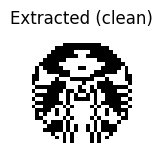

BER (jpeg q75): 0.2451171875


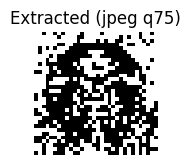

BER (small cutouts): 0.01171875


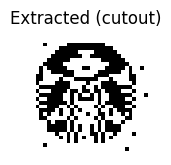

In [ ]:
"""
Simple DWT+DCT+SVD+QIM Watermarking (Blind, LL untouched, fixed seed)
---------------------------------------------------------------------

Design goals
- Keep logic simple and readable for assignments, but still reasonably robust.
- Work in Y (luma) only for perceptual stability; keep original Cb/Cr.
- Use 2-level DWT; embed ONLY in detail bands (H/V, optionally D). Never touch LL.
- Inside each selected DWT band tile:
    * 8×8 block DCT
    * SVD on a small mid-band patch
    * QIM on ONE singular value (σ_k) to encode each bit
- Deterministic block shuffling via a hard-coded seed (no secret key UI).
- Repetition + soft voting at extraction to survive mild distortions.

Tested idea: robust to JPEG ~70–90, small rescale (±5–10%), light Gaussian blur/noise,
and 1–2 tiny cutouts. More severe RST needs a sync/template; deliberately out-of-scope here.
"""

import math
import cv2
import numpy as np
from PIL import Image
import pywt
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

# =========================
# Adjustable hyperparameters
# =========================
DWT_LEVELS          = 2             # use 2-level DWT
USE_DIAGONAL_BAND   = True          # also use D (diagonal) bands? (still not LL)
TILES_PER_BAND      = (1, 1)        # spread bits spatially for cutout robustness
DCT_BLOCK_SIZE      = 8
SVD_PATCH_ROWS      = (2, 6)        # mid-band patch rows in an 8×8 DCT block [2..5]
SVD_PATCH_COLS      = (2, 6)        # mid-band patch cols in an 8×8 DCT block [2..5]
SVD_INDEX           = 0             # quantize σ_0 (largest singular value of the patch)
QIM_STEP            = 80
FIXED_SEED_BASE     = 0x20250830    # hard-coded seed; no secret-key input
WAVELET_NAME        = 'haar'        # simple and fast
WAVELET_MODE        = 'periodization'
WATERMARK_SIZE      = 32            # watermark will be 32×32 bits

# =========================
# Small utilities
# =========================
def show_watermark(wm, title="Watermark", scale=4, threshold=None, save_path=None):
    """
    Display a single watermark cleanly (crisp pixels, no axes).

    Args:
        wm         : np.ndarray of shape (H,W); values in {0,1} or grayscale [0..1]/[0..255]
        title      : optional figure title
        scale      : integer upscaling factor for display (e.g., 8 → 32x32 -> 256x256)
        threshold  : binarization threshold (auto: 0.5 if max<=1 else 127)
        save_path  : optional path to save the shown image

    Usage:
        bits = extract_watermark("./images/watermarked.png", 32)
        show_watermark(bits, title="Extracted")
    """
    a = np.asarray(wm)
    thr = (0.5 if a.max() <= 1.0 else 127) if threshold is None else threshold
    a_bin = (a > thr).astype(np.uint8)

    # Nearest-neighbor upscaling for crisp blocks
    if scale and scale > 1:
        a_disp = np.kron(a_bin, np.ones((scale, scale), dtype=np.uint8))
    else:
        a_disp = a_bin

    plt.figure(figsize=(a_disp.shape[1]/80, a_disp.shape[0]/80))  # simple size heuristic
    plt.imshow(a_disp, cmap="gray", vmin=0, vmax=1, interpolation="nearest")
    plt.title(title)
    plt.axis("off")
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

def psnr(img_a_u8, img_b_u8):
    a = img_a_u8.astype(np.float64)
    b = img_b_u8.astype(np.float64)
    mse = np.mean((a - b) ** 2)
    return 100.0 if mse <= 1e-12 else 20.0 * math.log10(255.0 / math.sqrt(mse))

def bit_error_rate(true_bits_u8, pred_bits_u8):
    true_bits_u8 = np.asarray(true_bits_u8).astype(np.uint8).ravel()
    pred_bits_u8 = np.asarray(pred_bits_u8).astype(np.uint8).ravel()
    assert true_bits_u8.size == pred_bits_u8.size, "Mismatch in bit lengths."
    return np.count_nonzero(true_bits_u8 ^ pred_bits_u8) / true_bits_u8.size

def to_ycbcr_arrays(pil_rgb):
    ycbcr = pil_rgb.convert("YCbCr")
    Y  = np.array(ycbcr.getchannel(0), dtype=np.float64)
    Cb = np.array(ycbcr.getchannel(1), dtype=np.uint8)
    Cr = np.array(ycbcr.getchannel(2), dtype=np.uint8)
    return Y, Cb, Cr

def from_ycbcr_arrays(Y_float, Cb_u8, Cr_u8):
    Y_u8 = np.rint(np.clip(Y_float, 0, 255)).astype(np.uint8)
    ycbcr = Image.merge("YCbCr", (Image.fromarray(Y_u8),
                                  Image.fromarray(Cb_u8),
                                  Image.fromarray(Cr_u8)))
    return ycbcr.convert("RGB")

def prepare_watermark_bits(path, size=WATERMARK_SIZE):
    """Load any image, make it grayscale, Otsu to binary, resize to size×size, return 0/1 bits."""
    img = Image.open(path).convert("L")
    arr = np.array(img, dtype=np.uint8)
    # Otsu threshold
    _, thr = cv2.threshold(arr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thr = Image.fromarray(thr).resize((size, size), Image.NEAREST)
    bits = (np.array(thr, dtype=np.uint8) > 127).astype(np.uint8)
    return bits

# =========================
# DWT helpers (multi-level)
# =========================
def dwt2_levels(img_2d, levels=DWT_LEVELS):
    return pywt.wavedec2(img_2d, wavelet=WAVELET_NAME, level=levels, mode=WAVELET_MODE)

def idwt2_levels(coeffs):
    return pywt.waverec2(coeffs, wavelet=WAVELET_NAME, mode=WAVELET_MODE)

def get_detail_bands_all_levels(coeffs, use_diag=USE_DIAGONAL_BAND):
    """
    Return list of tuples (level_idx, band_tag, band_array_ref),
    where band_tag in {'H','V'} plus 'D' if use_diag=True. Never returns LL.
    Level index: deepest is 'levels', then ... up to 1.
    """
    out = []
    levels = len(coeffs) - 1
    for l in range(levels, 0, -1):
        cH, cV, cD = coeffs[levels - l + 1]
        out.append((l, 'H', cH))
        out.append((l, 'V', cV))
        if use_diag:
            out.append((l, 'D', cD))
    return out

def set_detail_band(coeffs, level_idx, band_tag, new_arr):
    levels = len(coeffs) - 1
    i = levels - level_idx + 1
    cH, cV, cD = coeffs[i]
    if band_tag == 'H':
        coeffs[i] = (new_arr, cV, cD)
    elif band_tag == 'V':
        coeffs[i] = (cH, new_arr, cD)
    elif band_tag == 'D':
        coeffs[i] = (cH, cV, new_arr)

# =========================
# DCT (8×8 blockwise) helpers
# =========================
def dct_blocks_8x8(arr2d):
    H, W = arr2d.shape
    H8 = (H + 7) // 8 * 8
    W8 = (W + 7) // 8 * 8
    padded = np.pad(arr2d, ((0, H8 - H), (0, W8 - W)), mode='edge').astype(np.float64)
    D = np.empty((H8, W8), dtype=np.float64)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = padded[i:i+8, j:j+8]
            D[i:i+8, j:j+8] = dct(dct(blk.T, norm="ortho").T, norm="ortho")
    return D, H, W

def idct_blocks_8x8(D, H, W):
    H8, W8 = D.shape
    out = np.empty_like(D)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = D[i:i+8, j:j+8]
            out[i:i+8, j:j+8] = idct(idct(blk.T, norm="ortho").T, norm="ortho")
    return out[:H, :W]

# =========================
# QIM primitives (scalar)
# =========================
def qim_embed_scalar(x, bit, step):
    q = np.floor(x / step)
    return (q + (0.25 if bit == 0 else 0.75)) * step

def qim_llr_scalar(x, step):
    x /= step
    frac = x - np.floor(x)
    # >0 ⇒ closer to '1'; <0 ⇒ closer to '0'
    return abs(frac - 0.25) - abs(frac - 0.75)

# =========================
# SVD on mid-band patch (inside 8×8 DCT block)
# =========================
def svd_qim_embed_in_block(D8, bit, step, svd_idx=SVD_INDEX,
                           r_range=SVD_PATCH_ROWS, c_range=SVD_PATCH_COLS):
    r0, r1 = r_range; c0, c1 = c_range
    patch = D8[r0:r1, c0:c1]
    U, S, Vt = np.linalg.svd(patch, full_matrices=False)
    k = min(svd_idx, len(S) - 1)
    S[k] = qim_embed_scalar(S[k], int(bit), step)
    D8[r0:r1, c0:c1] = (U * S) @ Vt  # U @ diag(S) @ Vt

def svd_qim_llr_from_block(D8, step, svd_idx=SVD_INDEX,
                           r_range=SVD_PATCH_ROWS, c_range=SVD_PATCH_COLS):
    r0, r1 = r_range; c0, c1 = c_range
    patch = D8[r0:r1, c0:c1]
    _, S, _ = np.linalg.svd(patch, full_matrices=False)
    k = min(svd_idx, len(S) - 1)
    return qim_llr_scalar(S[k], step)

# =========================
# Tiling utility for spatial spread
# =========================
def tile_slices(H, W, tiles=TILES_PER_BAND):
    tr, tc = tiles
    hs = [0] + [(H * r) // tr for r in range(1, tr)] + [H]
    ws = [0] + [(W * c) // tc for c in range(1, tc)] + [W]
    for r in range(tr):
        for c in range(tc):
            yield slice(hs[r], hs[r+1]), slice(ws[c], ws[c+1]), r, c

# =========================
# Embedding (Y channel only)
# =========================
def embed_watermark_y(y_luma, wm_bits_2d):
    """
    Embed a size×size (e.g., 32×32) binary watermark into Y.
    - Never touches LL.
    - Deterministic shuffling from FIXED_SEED_BASE (no secret key input).
    """
    # Sanity on size
    H0, W0 = y_luma.shape
    if not (512 <= H0 <= 1080 and 512 <= W0 <= 1080):
        raise ValueError("Host image must be within 512–1080 px for BOTH height and width.")
    # Pad to align both DWT levels and 8×8 DCT
    stride = 1 << DWT_LEVELS
    mult = stride if stride >= 8 else 8
    Hp = (H0 + mult - 1) // mult * mult
    Wp = (W0 + mult - 1) // mult * mult
    y_pad = np.pad(y_luma, ((0, Hp - H0), (0, Wp - W0)), mode='edge')

    # DWT
    coeffs = dwt2_levels(y_pad, DWT_LEVELS)
    detail_bands = get_detail_bands_all_levels(coeffs, use_diag=USE_DIAGONAL_BAND)

    # Flatten watermark bits row-major
    wm_bits = wm_bits_2d.astype(np.uint8).ravel()
    n_bits  = wm_bits.size

    # For each detail band tile, run DCT→SVD+QIM on randomized blocks
    for lvl, tag, band in detail_bands:
        for rs, cs, tr, tc in tile_slices(*band.shape, TILES_PER_BAND):
            tile = band[rs, cs]
            D, Ht, Wt = dct_blocks_8x8(tile)
            H8, W8 = D.shape
            n_rows, n_cols = H8 // 8, W8 // 8
            n_blocks = n_rows * n_cols

            # Repetition plan: spread each bit over roughly floor(n_blocks/n_bits) blocks
            rep = max(1, n_blocks // n_bits)

            # Deterministic shuffle (no external key)
            tag_val = {'H': 11, 'V': 22, 'D': 33}[tag]
            seed = (FIXED_SEED_BASE ^ (lvl << 8) ^ (tr << 4) ^ tc ^ tag_val) & 0xFFFFFFFF
            rng = np.random.RandomState(seed)
            order = np.arange(n_blocks); rng.shuffle(order)

            pos = 0
            for b_idx, bit in enumerate(wm_bits):
                for _ in range(rep):
                    if pos >= n_blocks: break
                    k = int(order[pos]); pos += 1
                    r = k // n_cols; c = k % n_cols
                    i, j = r * 8, c * 8
                    svd_qim_embed_in_block(D[i:i+8, j:j+8], int(bit), QIM_STEP)

            band[rs, cs] = idct_blocks_8x8(D, Ht, Wt)
        set_detail_band(coeffs, lvl, tag, band)

    y_wm_pad = idwt2_levels(coeffs)
    return y_wm_pad[:H0, :W0]

# =========================
# Extraction (blind)
# =========================
def extract_watermark_y(y_luma, wm_size=WATERMARK_SIZE):
    """
    Blind extraction: replicate the same band/tile/block traversal and do soft voting
    from QIM LLRs to recover bits (>=0 → 1 else 0).
    """
    H0, W0 = y_luma.shape
    stride = 1 << DWT_LEVELS
    mult = stride if stride >= 8 else 8
    Hp = (H0 + mult - 1) // mult * mult
    Wp = (W0 + mult - 1) // mult * mult
    y_pad = np.pad(y_luma, ((0, Hp - H0), (0, Wp - W0)), mode='edge')

    coeffs = dwt2_levels(y_pad, DWT_LEVELS)
    detail_bands = get_detail_bands_all_levels(coeffs, use_diag=USE_DIAGONAL_BAND)

    n_bits = wm_size * wm_size
    soft_sum = np.zeros(n_bits, dtype=np.float64)

    for lvl, tag, band in detail_bands:
        for rs, cs, tr, tc in tile_slices(*band.shape, TILES_PER_BAND):
            tile = band[rs, cs]
            D, Ht, Wt = dct_blocks_8x8(tile)
            H8, W8 = D.shape
            n_rows, n_cols = H8 // 8, W8 // 8
            n_blocks = n_rows * n_cols
            rep = max(1, n_blocks // n_bits)

            tag_val = {'H': 11, 'V': 22, 'D': 33}[tag]
            seed = (FIXED_SEED_BASE ^ (lvl << 8) ^ (tr << 4) ^ tc ^ tag_val) & 0xFFFFFFFF
            rng = np.random.RandomState(seed)
            order = np.arange(n_blocks); rng.shuffle(order)

            pos = 0
            for b_idx in range(n_bits):
                score = 0.0
                for _ in range(rep):
                    if pos >= n_blocks: break
                    k = int(order[pos]); pos += 1
                    r = k // n_cols; c = k % n_cols
                    i, j = r * 8, c * 8
                    score += svd_qim_llr_from_block(D[i:i+8, j:j+8], QIM_STEP)
                soft_sum[b_idx] += score

    bits = (soft_sum >= 0).astype(np.uint8)
    return bits.reshape(wm_size, wm_size)

# =========================
# High-level convenience I/O
# =========================
def embed_watermark(host_path, wm_path, out_path="watermarked.png"):
    # Load RGB and split YCbCr
    rgb = Image.open(host_path).convert("RGB")
    Y, Cb, Cr = to_ycbcr_arrays(rgb)
    # Prepare watermark bits
    wm_bits = prepare_watermark_bits(wm_path, WATERMARK_SIZE)
    # Embed into Y (LL untouched)
    Y_wm = embed_watermark_y(Y, wm_bits)
    # Merge back and save
    out_rgb = from_ycbcr_arrays(Y_wm, Cb, Cr)
    out_rgb.save(out_path)
    return np.array(rgb, dtype=np.uint8), np.array(out_rgb, dtype=np.uint8), wm_bits

def extract_watermark(watermarked_or_attacked_path, wm_size=WATERMARK_SIZE):
    rgb = Image.open(watermarked_or_attacked_path).convert("RGB")
    Y, _, _ = to_ycbcr_arrays(rgb)
    wm_bits = extract_watermark_y(Y, wm_size)
    return wm_bits

# =========================
# (Optional) tiny attack helpers for quick tests
# =========================
def attack_jpeg(in_path, out_path, quality=80):
    Image.open(in_path).convert("RGB").save(out_path, quality=quality, subsampling=0, optimize=False)

def attack_small_resize(in_path, out_path, scale=0.9):
    img = Image.open(in_path).convert("RGB")
    w, h = img.size
    img2 = img.resize((max(1, int(w*scale)), max(1, int(h*scale))), Image.LANCZOS)
    img3 = img2.resize((w, h), Image.LANCZOS)
    img3.save(out_path)

def attack_blur(in_path, out_path, k=3):
    arr = np.array(Image.open(in_path).convert("RGB"), dtype=np.uint8)
    k = k if k % 2 == 1 else k+1
    arrb = cv2.GaussianBlur(arr, (k, k), 0)
    Image.fromarray(arrb).save(out_path)

def attack_small_cutout(in_path, out_path,
                        area_ratio=0.008,     # ~0.8% of the whole image area per patch
                        num_patches=2,        # number of cutouts
                        shape="rect",         # "rect" or "circle"
                        fill="noise",         # "noise" | "black" | "avg" | "blur" | "inpaint"
                        blur_kernel=11,       # odd kernel size if fill="blur"
                        seed=2025):
    """
    Apply 1..N tiny cutouts while keeping the same output size.

    - area_ratio controls the approx area of EACH patch relative to the full image.
      w ≈ sqrt(area_ratio) * W, h ≈ sqrt(area_ratio) * H
    - shape selects rectangle or circular cutouts.
    - fill chooses how to fill the missing region:
        * "noise": random RGB, harsh but common on social uploads
        * "black": zero pixels
        * "avg":   fill with global average color (mild artifact)
        * "blur":  fill with a Gaussian-blurred version
        * "inpaint": OpenCV Telea inpaint using the patch mask (slowest, most realistic)
    """
    # --- Load image as uint8 RGB
    img = Image.open(in_path).convert("RGB")
    arr = np.array(img, dtype=np.uint8)
    H, W, C = arr.shape
    rng = np.random.default_rng(seed)

    # Precompute blurred image if needed
    if fill == "blur":
        k = blur_kernel if blur_kernel % 2 == 1 else blur_kernel + 1
        blurred = cv2.GaussianBlur(arr, (k, k), 0)

    # Helpers to build masks
    def rect_mask(x0, y0, w, h):
        m = np.zeros((H, W), dtype=np.uint8)
        m[y0:y0+h, x0:x0+w] = 255
        return m

    def circle_mask(x0, y0, w, h):
        m = np.zeros((H, W), dtype=np.uint8)
        cy, cx = y0 + h // 2, x0 + w // 2
        r = int(0.5 * max(w, h))
        yy, xx = np.ogrid[:H, :W]
        m[(yy - cy) ** 2 + (xx - cx) ** 2 <= r * r] = 255
        return m

    # Global mean color (for "avg" fill)
    global_mean = arr.reshape(-1, C).mean(axis=0).astype(np.uint8)

    # If we plan to inpaint, accumulate a single mask and run inpaint once at the end
    inpaint_accum_mask = np.zeros((H, W), dtype=np.uint8)

    # --- Create and apply patches
    for _ in range(max(1, int(num_patches))):
        # Patch size chosen so area ≈ area_ratio * (W*H)
        w = max(1, int(round(np.sqrt(area_ratio) * W)))
        h = max(1, int(round(np.sqrt(area_ratio) * H)))
        x0 = int(rng.integers(0, max(1, W - w)))
        y0 = int(rng.integers(0, max(1, H - h)))

        mask = rect_mask(x0, y0, w, h) if shape == "rect" else circle_mask(x0, y0, w, h)

        if fill == "black":
            arr[mask == 255] = 0
        elif fill == "avg":
            arr[mask == 255] = global_mean
        elif fill == "noise":
            noise = rng.integers(0, 256, size=(H, W, C), dtype=np.uint8)
            arr[mask == 255] = noise[mask == 255]
        elif fill == "blur":
            arr[mask == 255] = blurred[mask == 255]
        elif fill == "inpaint":
            inpaint_accum_mask = np.maximum(inpaint_accum_mask, mask)
        else:
            raise ValueError("fill must be one of: 'noise','black','avg','blur','inpaint'")

    # Run inpaint once if requested
    if fill == "inpaint" and np.any(inpaint_accum_mask):
        bgr = cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
        bgr = cv2.inpaint(bgr, inpaint_accum_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
        arr = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    Image.fromarray(arr).save(out_path)


# =========================
# Example usage (uncomment to run locally)
# =========================
host_path = "./images/i800.png"
wm_path   = "./images/s.jpg"
watermarked_path = "./images/watermarked.png"

# Embed
host_u8, wm_u8, wm_bits_true = embed_watermark(host_path, wm_path, watermarked_path)
print("PSNR host vs watermarked:", psnr(host_u8, wm_u8), "dB")

# Extract from clean watermarked
bits_clean = extract_watermark(watermarked_path, WATERMARK_SIZE)
print("BER (clean):", bit_error_rate(wm_bits_true, bits_clean))
show_watermark(bits_clean, title="Extracted (clean)")

# # Extract from whatsapp watermarked
# bits_whatsapp = extract_watermark(r"C:\Users\Vin Sen\Downloads\WhatsApp Image 2025-08-30 at 10.40.27_8defa68e.jpg", WATERMARK_SIZE)
# print("BER (whatsapp):", bit_error_rate(wm_bits_true, bits_whatsapp))
# show_watermark(bits_whatsapp, title="Extracted (whatsapp)")

# Attack: JPEG then extract
attack_jpeg(watermarked_path, "./images/wm_jpeg75.jpg", quality=75)
bits_jpeg = extract_watermark("./images/wm_jpeg75.jpg", WATERMARK_SIZE)
print("BER (jpeg q75):", bit_error_rate(wm_bits_true, bits_jpeg))
show_watermark(bits_jpeg, title="Extracted (jpeg q75)")

# Assume you already produced "./images/watermarked.png"
attack_small_cutout("./images/watermarked.png",
                    "./images/wm_cutout_black.png",
                    area_ratio=0.1,   # ≈0.6% per patch
                    num_patches=1,
                    shape="rect",
                    fill="black",
                    seed=42)

# Then try to extract:
bits_cutout = extract_watermark("./images/wm_cutout_black.png", WATERMARK_SIZE)
print("BER (small cutouts):", bit_error_rate(wm_bits_true, bits_cutout))
show_watermark(bits_cutout, title="Extracted (cutout)")

# No Tiling

PSNR host vs watermarked: 33.534216807273 dB
BER (clean): 0.0


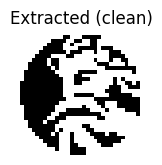

BER (jpeg q75): 0.1318359375


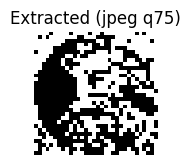

BER (small cutout): 0.0087890625


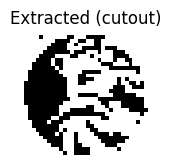

In [94]:
"""
Simple DWT+DCT+SVD+QIM Watermarking (NO TILING, Blind, LL untouched, fixed seed)
---------------------------------------------------------------------------------

- Work in Y (luma) only; keep original Cb/Cr.
- 2-level DWT; embed ONLY in detail bands (H/V, optionally D). Never touch LL.
- For each (level, band):
    * 8×8 block DCT over the whole band (one big region; no tiling)
    * In each 8×8 block, take a 4×4 mid-band patch [2:6, 2:6]
    * SVD that patch; QIM-quantize a single singular value (σ_k)
- Deterministic shuffle with a hard-coded seed (no user key).
- Repetition factor per bit ≈ floor(#blocks / #bits) in each band; soft voting at extraction.

Tip: Start QIM_STEP around 4.0–6.0; increase for robustness, decrease for quality.
"""

import math
import cv2
import numpy as np
from PIL import Image
import pywt
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

# =========================
# Adjustable hyperparameters
# =========================
DWT_LEVELS          = 2             # 2-level DWT
USE_DIAGONAL_BAND   = True          # also use D (diagonal) bands? (still not LL)
DCT_BLOCK_SIZE      = 8
SVD_PATCH_ROWS      = (1, 5)        # mid-band patch rows in an 8×8 DCT block [2..5]
SVD_PATCH_COLS      = (1, 5)        # mid-band patch cols in an 8×8 DCT block [2..5]
SVD_INDEX           = 0             # quantize σ_0 (largest singular value of the patch)
QIM_STEP            = 100.0           # ↑ for robustness, ↓ for image quality
FIXED_SEED_BASE     = 0
WAVELET_NAME        = 'haar'
WAVELET_MODE        = 'symmetric'
WATERMARK_SIZE      = 32            # watermark will be 32×32 bits

# =========================
# Small utilities
# =========================
def show_watermark(wm, title="Watermark", scale=4, threshold=None, save_path=None):
    a = np.asarray(wm)
    thr = (0.5 if a.max() <= 1.0 else 127) if threshold is None else threshold
    a_bin = (a > thr).astype(np.uint8)
    a_disp = np.kron(a_bin, np.ones((max(1, int(scale)), max(1, int(scale))), dtype=np.uint8))
    plt.figure(figsize=(a_disp.shape[1]/80, a_disp.shape[0]/80))
    plt.imshow(a_disp, cmap="gray", vmin=0, vmax=1, interpolation="nearest")
    plt.title(title); plt.axis("off")
    if save_path: plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

def psnr(img_a_u8, img_b_u8):
    a = img_a_u8.astype(np.float64)
    b = img_b_u8.astype(np.float64)
    mse = np.mean((a - b) ** 2)
    return 100.0 if mse <= 1e-12 else 20.0 * math.log10(255.0 / math.sqrt(mse))

def bit_error_rate(true_bits_u8, pred_bits_u8):
    true_bits_u8 = np.asarray(true_bits_u8).astype(np.uint8).ravel()
    pred_bits_u8 = np.asarray(pred_bits_u8).astype(np.uint8).ravel()
    assert true_bits_u8.size == pred_bits_u8.size, "Mismatch in bit lengths."
    return np.count_nonzero(true_bits_u8 ^ pred_bits_u8) / true_bits_u8.size

def to_ycbcr_arrays(pil_rgb):
    ycbcr = pil_rgb.convert("YCbCr")
    Y  = np.array(ycbcr.getchannel(0), dtype=np.float64)
    Cb = np.array(ycbcr.getchannel(1), dtype=np.uint8)
    Cr = np.array(ycbcr.getchannel(2), dtype=np.uint8)
    return Y, Cb, Cr

def from_ycbcr_arrays(Y_float, Cb_u8, Cr_u8):
    Y_u8 = np.rint(np.clip(Y_float, 0, 255)).astype(np.uint8)
    ycbcr = Image.merge("YCbCr", (Image.fromarray(Y_u8),
                                  Image.fromarray(Cb_u8),
                                  Image.fromarray(Cr_u8)))
    return ycbcr.convert("RGB")

def prepare_watermark_bits(path, size=WATERMARK_SIZE):
    """Load any image, grayscale→Otsu binary→resize to size×size, return 0/1 bits."""
    img = Image.open(path).convert("L")
    arr = np.array(img, dtype=np.uint8)
    _, thr = cv2.threshold(arr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thr = Image.fromarray(thr).resize((size, size), Image.NEAREST)
    bits = (np.array(thr, dtype=np.uint8) > 127).astype(np.uint8)
    return bits

# =========================
# DWT helpers (multi-level)
# =========================
def dwt2_levels(img_2d, levels=DWT_LEVELS):
    return pywt.wavedec2(img_2d, wavelet=WAVELET_NAME, level=levels, mode=WAVELET_MODE)

def idwt2_levels(coeffs):
    return pywt.waverec2(coeffs, wavelet=WAVELET_NAME, mode=WAVELET_MODE)

def get_detail_bands_all_levels(coeffs, use_diag=USE_DIAGONAL_BAND):
    """
    Return [(level_idx, band_tag, band_array_ref)] for detail bands only.
    band_tag ∈ {'H','V'} plus 'D' if use_diag=True. LL is excluded.
    """
    out = []
    levels = len(coeffs) - 1
    for l in range(levels, 0, -1):
        cH, cV, cD = coeffs[levels - l + 1]
        out.append((l, 'H', cH))
        out.append((l, 'V', cV))
        if use_diag:
            out.append((l, 'D', cD))
    return out

def set_detail_band(coeffs, level_idx, band_tag, new_arr):
    levels = len(coeffs) - 1
    i = levels - level_idx + 1
    cH, cV, cD = coeffs[i]
    if band_tag == 'H':
        coeffs[i] = (new_arr, cV, cD)
    elif band_tag == 'V':
        coeffs[i] = (cH, new_arr, cD)
    elif band_tag == 'D':
        coeffs[i] = (cH, cV, new_arr)

# =========================
# DCT (8×8 blockwise) helpers
# =========================
def dct_blocks_8x8(arr2d):
    H, W = arr2d.shape
    H8 = (H + 7) // 8 * 8
    W8 = (W + 7) // 8 * 8
    padded = np.pad(arr2d, ((0, H8 - H), (0, W8 - W)), mode='edge').astype(np.float64)
    D = np.empty((H8, W8), dtype=np.float64)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = padded[i:i+8, j:j+8]
            D[i:i+8, j:j+8] = dct(dct(blk.T, norm="ortho").T, norm="ortho")
    return D, H, W

def idct_blocks_8x8(D, H, W):
    H8, W8 = D.shape
    out = np.empty_like(D)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = D[i:i+8, j:j+8]
            out[i:i+8, j:j+8] = idct(idct(blk.T, norm="ortho").T, norm="ortho")
    return out[:H, :W]

# =========================
# QIM primitives (scalar)
# =========================
def qim_embed_scalar(x, bit, step):
    q = np.floor(x / step)
    return (q + (0.25 if bit == 0 else 0.75)) * step

def qim_llr_scalar(x, step):
    x /= step
    frac = x - np.floor(x)
    return abs(frac - 0.25) - abs(frac - 0.75)  # >0 ⇒ closer to bit=1

# =========================
# SVD on mid-band patch (inside 8×8 DCT block)
# =========================
def svd_qim_embed_in_block(D8, bit, step, svd_idx=SVD_INDEX,
                           r_range=SVD_PATCH_ROWS, c_range=SVD_PATCH_COLS):
    r0, r1 = r_range; c0, c1 = c_range
    patch = D8[r0:r1, c0:c1]
    U, S, Vt = np.linalg.svd(patch, full_matrices=False)
    k = min(svd_idx, len(S) - 1)
    S[k] = qim_embed_scalar(S[k], int(bit), step)
    D8[r0:r1, c0:c1] = (U * S) @ Vt  # U @ diag(S) @ Vt

def svd_qim_llr_from_block(D8, step, svd_idx=SVD_INDEX,
                           r_range=SVD_PATCH_ROWS, c_range=SVD_PATCH_COLS):
    r0, r1 = r_range; c0, c1 = c_range
    patch = D8[r0:r1, c0:c1]
    _, S, _ = np.linalg.svd(patch, full_matrices=False)
    k = min(svd_idx, len(S) - 1)
    return qim_llr_scalar(S[k], step)

# =========================
# Embedding (Y channel only) — NO TILING
# =========================
def embed_watermark_y(y_luma, wm_bits_2d):
    """
    Embed a size×size (e.g., 32×32) binary watermark into Y.
    - Never touches LL.
    - Deterministic shuffling from FIXED_SEED_BASE (no secret key input).
    - NO TILING: one shuffle per (level, band).
    """
    H0, W0 = y_luma.shape
    if not (512 <= H0 <= 1080 and 512 <= W0 <= 1080):
        raise ValueError("Host image must be within 512–1080 px on BOTH height and width.")

    # Pad to align both DWT levels and 8×8 DCT
    stride = 1 << DWT_LEVELS
    mult = stride if stride >= 8 else 8
    Hp = (H0 + mult - 1) // mult * mult
    Wp = (W0 + mult - 1) // mult * mult
    y_pad = np.pad(y_luma, ((0, Hp - H0), (0, Wp - W0)), mode='edge')

    # DWT
    coeffs = dwt2_levels(y_pad, DWT_LEVELS)
    detail_bands = get_detail_bands_all_levels(coeffs, use_diag=USE_DIAGONAL_BAND)

    wm_bits = wm_bits_2d.astype(np.uint8).ravel()
    n_bits  = wm_bits.size

    for lvl, tag, band in detail_bands:
        # One big region per band
        D, Hb, Wb = dct_blocks_8x8(band)
        H8, W8 = D.shape
        n_rows, n_cols = H8 // 8, W8 // 8
        n_blocks = n_rows * n_cols

        # How many repetitions per bit within this band
        rep = max(1, n_blocks // n_bits)

        # Deterministic block shuffle for this (level, band)
        tag_val = {'H': 11, 'V': 22, 'D': 33}[tag]
        seed = (FIXED_SEED_BASE ^ (lvl << 8) ^ tag_val) & 0xFFFFFFFF
        rng = np.random.RandomState(seed)
        order = np.arange(n_blocks); rng.shuffle(order)

        pos = 0
        for b_idx, bit in enumerate(wm_bits):
            for _ in range(rep):
                if pos >= n_blocks: break
                k = int(order[pos]); pos += 1
                r = k // n_cols; c = k % n_cols
                i, j = r * 8, c * 8
                svd_qim_embed_in_block(D[i:i+8, j:j+8], int(bit), QIM_STEP)

        # Write back this band
        band[:] = idct_blocks_8x8(D, Hb, Wb)
        set_detail_band(coeffs, lvl, tag, band)

    y_wm_pad = idwt2_levels(coeffs)
    return y_wm_pad[:H0, :W0]

# =========================
# Extraction (blind) — NO TILING
# =========================
def extract_watermark_y(y_luma, wm_size=WATERMARK_SIZE):
    """
    Blind extraction with soft voting across all used (level, band).
    Mirrors the no-tiling traversal and block shuffles.
    """
    H0, W0 = y_luma.shape
    stride = 1 << DWT_LEVELS
    mult = stride if stride >= 8 else 8
    Hp = (H0 + mult - 1) // mult * mult
    Wp = (W0 + mult - 1) // mult * mult
    y_pad = np.pad(y_luma, ((0, Hp - H0), (0, Wp - W0)), mode='edge')

    coeffs = dwt2_levels(y_pad, DWT_LEVELS)
    detail_bands = get_detail_bands_all_levels(coeffs, use_diag=USE_DIAGONAL_BAND)

    n_bits = wm_size * wm_size
    soft_sum = np.zeros(n_bits, dtype=np.float64)

    for lvl, tag, band in detail_bands:
        D, Hb, Wb = dct_blocks_8x8(band)
        H8, W8 = D.shape
        n_rows, n_cols = H8 // 8, W8 // 8
        n_blocks = n_rows * n_cols
        rep = max(1, n_blocks // n_bits)

        tag_val = {'H': 11, 'V': 22, 'D': 33}[tag]
        seed = (FIXED_SEED_BASE ^ (lvl << 8) ^ tag_val) & 0xFFFFFFFF
        rng = np.random.RandomState(seed)
        order = np.arange(n_blocks); rng.shuffle(order)

        pos = 0
        for b_idx in range(n_bits):
            score = 0.0
            for _ in range(rep):
                if pos >= n_blocks: break
                k = int(order[pos]); pos += 1
                r = k // n_cols; c = k % n_cols
                i, j = r * 8, c * 8
                score += svd_qim_llr_from_block(D[i:i+8, j:j+8], QIM_STEP)
            soft_sum[b_idx] += score

    bits = (soft_sum >= 0).astype(np.uint8)
    return bits.reshape(wm_size, wm_size)

# =========================
# High-level convenience I/O
# =========================
def embed_watermark(host_path, wm_path, out_path="watermarked.png"):
    rgb = Image.open(host_path).convert("RGB")
    Y, Cb, Cr = to_ycbcr_arrays(rgb)
    wm_bits = prepare_watermark_bits(wm_path, WATERMARK_SIZE)
    Y_wm = embed_watermark_y(Y, wm_bits)
    out_rgb = from_ycbcr_arrays(Y_wm, Cb, Cr)
    out_rgb.save(out_path)
    return np.array(rgb, dtype=np.uint8), np.array(out_rgb, dtype=np.uint8), wm_bits

def extract_watermark(image_path, wm_size=WATERMARK_SIZE):
    rgb = Image.open(image_path).convert("RGB")
    Y, _, _ = to_ycbcr_arrays(rgb)
    wm_bits = extract_watermark_y(Y, wm_size)
    return wm_bits

# =========================
# Attack helpers (optional)
# =========================
def attack_jpeg(in_path, out_path, quality=80):
    Image.open(in_path).convert("RGB").save(out_path, quality=quality, subsampling=0, optimize=False)

def attack_small_resize(in_path, out_path, scale=0.9):
    img = Image.open(in_path).convert("RGB")
    w, h = img.size
    img2 = img.resize((max(1, int(w*scale)), max(1, int(h*scale))), Image.LANCZOS)
    img3 = img2.resize((w, h), Image.LANCZOS)
    img3.save(out_path)

def attack_blur(in_path, out_path, k=3):
    arr = np.array(Image.open(in_path).convert("RGB"), dtype=np.uint8)
    k = k if k % 2 == 1 else k+1
    arrb = cv2.GaussianBlur(arr, (k, k), 0)
    Image.fromarray(arrb).save(out_path)

def attack_small_cutout(in_path, out_path,
                        area_ratio=0.008,     # ≈0.8% of full image area per patch
                        num_patches=2,
                        shape="rect",         # "rect" | "circle"
                        fill="noise",         # "noise" | "black" | "avg" | "blur" | "inpaint"
                        blur_kernel=11,
                        seed=2025):
    img = Image.open(in_path).convert("RGB")
    arr = np.array(img, dtype=np.uint8)
    H, W, C = arr.shape
    rng = np.random.default_rng(seed)

    if fill == "blur":
        k = blur_kernel if blur_kernel % 2 == 1 else blur_kernel + 1
        blurred = cv2.GaussianBlur(arr, (k, k), 0)

    def rect_mask(x0, y0, w, h):
        m = np.zeros((H, W), dtype=np.uint8); m[y0:y0+h, x0:x0+w] = 255; return m

    def circle_mask(x0, y0, w, h):
        m = np.zeros((H, W), dtype=np.uint8)
        cy, cx = y0 + h // 2, x0 + w // 2; r = int(0.5 * max(w, h))
        yy, xx = np.ogrid[:H, :W]; m[(yy - cy)**2 + (xx - cx)**2 <= r*r] = 255; return m

    global_mean = arr.reshape(-1, C).mean(axis=0).astype(np.uint8)
    inpaint_accum_mask = np.zeros((H, W), dtype=np.uint8)

    for _ in range(max(1, int(num_patches))):
        w = max(1, int(round(np.sqrt(area_ratio) * W)))
        h = max(1, int(round(np.sqrt(area_ratio) * H)))
        x0 = int(rng.integers(0, max(1, W - w))); y0 = int(rng.integers(0, max(1, H - h)))
        mask = rect_mask(x0, y0, w, h) if shape == "rect" else circle_mask(x0, y0, w, h)

        if fill == "black":
            arr[mask == 255] = 0
        elif fill == "avg":
            arr[mask == 255] = global_mean
        elif fill == "noise":
            noise = rng.integers(0, 256, size=(H, W, C), dtype=np.uint8)
            arr[mask == 255] = noise[mask == 255]
        elif fill == "blur":
            arr[mask == 255] = blurred[mask == 255]
        elif fill == "inpaint":
            inpaint_accum_mask = np.maximum(inpaint_accum_mask, mask)
        else:
            raise ValueError("fill must be one of: 'noise','black','avg','blur','inpaint'")

    if fill == "inpaint" and np.any(inpaint_accum_mask):
        bgr = cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
        bgr = cv2.inpaint(bgr, inpaint_accum_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
        arr = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    Image.fromarray(arr).save(out_path)

# =========================
# Example usage (uncomment to run locally)
# =========================
if __name__ == "__main__":
    host_path = "./images/i800.png"
    wm_path   = "./images/image512.jpg"
    out_path  = "./images/watermarked.png"

    # Embed
    host_u8, watermarked_u8, wm_bits_true = embed_watermark(host_path, wm_path, out_path)
    print("PSNR host vs watermarked:", psnr(host_u8, watermarked_u8), "dB")

    # Extract from clean watermarked
    bits_clean = extract_watermark(out_path, WATERMARK_SIZE)
    print("BER (clean):", bit_error_rate(wm_bits_true, bits_clean))
    show_watermark(bits_clean, title="Extracted (clean)")

    # JPEG attack
    attack_jpeg(out_path, "./images/wm_jpeg75.jpg", quality=75)
    bits_jpeg = extract_watermark("./images/wm_jpeg75.jpg", WATERMARK_SIZE)
    print("BER (jpeg q75):", bit_error_rate(wm_bits_true, bits_jpeg))
    show_watermark(bits_jpeg, title="Extracted (jpeg q75)")

    # Small cutout attack
    attack_small_cutout(out_path, "./images/wm_cutout_black.png",
                        area_ratio=0.1, num_patches=1, shape="rect", fill="black", seed=42)
    bits_cut = extract_watermark("./images/wm_cutout_black.png", WATERMARK_SIZE)
    print("BER (small cutout):", bit_error_rate(wm_bits_true, bits_cut))
    show_watermark(bits_cut, title="Extracted (cutout)")


# No random seed

PSNR host vs watermarked: 34.09020073575189 dB
BER (clean): 0.0537109375


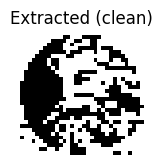

BER (jpeg q75): 0.044921875


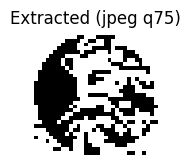

BER (small cutout): 0.1005859375


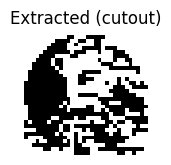

In [49]:
"""
Simple DWT+DCT+SVD+QIM Watermarking (NO TILING, NO RANDOM SEED, Blind, LL untouched)
------------------------------------------------------------------------------------

Design
- Work in Y (luma) channel only; keep original Cb/Cr untouched.
- 2-level DWT; embed ONLY in detail bands (H/V and optionally D). Never touch LL.
- For each (level, band):
    * 8×8 block DCT over the whole band (one big region; no tiling)
    * Use a 4×4 mid/low-mid patch inside each 8×8 block (rows/cols [1:5])
    * SVD that 4×4 patch; QIM-quantize ONE singular value (σ_k) to encode bits
- Deterministic, seedless mapping: round-robin across blocks (block k → bit k % n_bits)
- Repetition comes automatically when #blocks > #bits. Soft voting at extraction.

Notes
- Large QIM_STEP (e.g., 80–120) increases JPEG robustness but reduces image quality (PSNR).
- Keep host image size within 512–1080 px on BOTH height and width.
"""

import math
import cv2
import numpy as np
from PIL import Image
import pywt
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

# =========================
# Adjustable hyperparameters
# =========================
DWT_LEVELS        = 3              # 2-level DWT
USE_DIAGONAL_BAND = False           # include diagonal (D) bands as well (still NO LL)
DCT_BLOCK_SIZE    = 8
SVD_PATCH_ROWS    = (0, 7)         # 4x4 patch rows in an 8×8 DCT block: rows 2..5
SVD_PATCH_COLS    = (0, 7)         # 4x4 patch cols in an 8×8 DCT block: cols 2..5
SVD_INDEX         = 0              # quantize σ_0 (largest singular value of the patch)
QIM_STEP          = 100.0
WAVELET_NAME      = 'haar'
WAVELET_MODE      = 'symmetric'
WATERMARK_SIZE    = 32             # watermark is 32×32 binary

# =========================
# Small utilities
# =========================
def show_watermark(wm, title="Watermark", scale=4, threshold=None, save_path=None):
    """Display a single watermark (binarize if needed) with crisp pixels."""
    a = np.asarray(wm)
    thr = (0.5 if a.max() <= 1.0 else 127) if threshold is None else threshold
    a_bin = (a > thr).astype(np.uint8)
    a_disp = np.kron(a_bin, np.ones((max(1, int(scale)), max(1, int(scale))), dtype=np.uint8))
    plt.figure(figsize=(a_disp.shape[1]/80, a_disp.shape[0]/80))
    plt.imshow(a_disp, cmap="gray", vmin=0, vmax=1, interpolation="nearest")
    plt.title(title); plt.axis("off")
    if save_path: plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

def psnr(img_a_u8, img_b_u8):
    a = img_a_u8.astype(np.float64)
    b = img_b_u8.astype(np.float64)
    mse = np.mean((a - b) ** 2)
    return 100.0 if mse <= 1e-12 else 20.0 * math.log10(255.0 / math.sqrt(mse))

def bit_error_rate(true_bits_u8, pred_bits_u8):
    true_bits_u8 = np.asarray(true_bits_u8).astype(np.uint8).ravel()
    pred_bits_u8 = np.asarray(pred_bits_u8).astype(np.uint8).ravel()
    assert true_bits_u8.size == pred_bits_u8.size, "Mismatch in bit lengths."
    return np.count_nonzero(true_bits_u8 ^ pred_bits_u8) / true_bits_u8.size

def to_ycbcr_arrays(pil_rgb):
    """Return Y (float64), Cb (uint8), Cr (uint8)."""
    ycbcr = pil_rgb.convert("YCbCr")
    Y  = np.array(ycbcr.getchannel(0), dtype=np.float64)
    Cb = np.array(ycbcr.getchannel(1), dtype=np.uint8)
    Cr = np.array(ycbcr.getchannel(2), dtype=np.uint8)
    return Y, Cb, Cr

def from_ycbcr_arrays(Y_float, Cb_u8, Cr_u8):
    """Merge Y, Cb, Cr back to RGB (uint8)."""
    Y_u8 = np.rint(np.clip(Y_float, 0, 255)).astype(np.uint8)
    ycbcr = Image.merge("YCbCr", (Image.fromarray(Y_u8),
                                  Image.fromarray(Cb_u8),
                                  Image.fromarray(Cr_u8)))
    return ycbcr.convert("RGB")

def prepare_watermark_bits(path, size=WATERMARK_SIZE):
    """Load any image → grayscale → Otsu → resize to size×size, return 0/1 bits."""
    img = Image.open(path).convert("L")
    arr = np.array(img, dtype=np.uint8)
    _, thr = cv2.threshold(arr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thr = Image.fromarray(thr).resize((size, size), Image.NEAREST)
    bits = (np.array(thr, dtype=np.uint8) > 127).astype(np.uint8)
    return bits

# =========================
# DWT helpers (multi-level)
# =========================
def dwt2_levels(img_2d, levels=DWT_LEVELS):
    return pywt.wavedec2(img_2d, wavelet=WAVELET_NAME, level=levels, mode=WAVELET_MODE)

def idwt2_levels(coeffs):
    return pywt.waverec2(coeffs, wavelet=WAVELET_NAME, mode=WAVELET_MODE)

def get_detail_bands_all_levels(coeffs, use_diag=USE_DIAGONAL_BAND):
    """
    Return a list of (level_idx, band_tag, band_array_ref) for detail bands only.
    band_tag ∈ {'H','V'} + {'D'} if use_diag=True. LL is EXCLUDED.
    """
    out = []
    levels = len(coeffs) - 1
    for l in range(levels, 0, -1):
        cH, cV, cD = coeffs[levels - l + 1]
        out.append((l, 'H', cH))
        out.append((l, 'V', cV))
        if use_diag:
            out.append((l, 'D', cD))
    return out

def set_detail_band(coeffs, level_idx, band_tag, new_arr):
    """Write back a specific detail band at a given level."""
    levels = len(coeffs) - 1
    i = levels - level_idx + 1
    cH, cV, cD = coeffs[i]
    if band_tag == 'H':
        coeffs[i] = (new_arr, cV, cD)
    elif band_tag == 'V':
        coeffs[i] = (cH, new_arr, cD)
    elif band_tag == 'D':
        coeffs[i] = (cH, cV, new_arr)

# =========================
# DCT (8×8 blockwise) helpers
# =========================
def dct_blocks_8x8(arr2d):
    """Blockwise 8×8 DCT with edge padding to multiples of 8."""
    H, W = arr2d.shape
    H8 = (H + 7) // 8 * 8
    W8 = (W + 7) // 8 * 8
    padded = np.pad(arr2d, ((0, H8 - H), (0, W8 - W)), mode='edge').astype(np.float64)
    D = np.empty((H8, W8), dtype=np.float64)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = padded[i:i+8, j:j+8]
            D[i:i+8, j:j+8] = dct(dct(blk.T, norm="ortho").T, norm="ortho")
    return D, H, W

def idct_blocks_8x8(D, H, W):
    """Inverse blockwise 8×8 DCT; crop back to original size."""
    H8, W8 = D.shape
    out = np.empty_like(D)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = D[i:i+8, j:j+8]
            out[i:i+8, j:j+8] = idct(idct(blk.T, norm="ortho").T, norm="ortho")
    return out[:H, :W]

# =========================
# QIM primitives (scalar) on a single value
# =========================
def qim_embed_scalar(x, bit, step):
    """Quantize x into the center of the bit-labeled interval with step Δ=step."""
    q = np.floor(x / step)
    return (q + (0.25 if bit == 0 else 0.75)) * step

def qim_llr_scalar(x, step):
    """Soft-decision score: >0 means closer to bit=1; <0 closer to bit=0."""
    x /= step
    frac = x - np.floor(x)
    return abs(frac - 0.25) - abs(frac - 0.75)

# =========================
# SVD-on-patch helpers (inside an 8×8 DCT block)
# =========================
def svd_qim_embed_in_block(D8, bit, step, svd_idx=SVD_INDEX,
                           r_range=SVD_PATCH_ROWS, c_range=SVD_PATCH_COLS):
    r0, r1 = r_range; c0, c1 = c_range
    patch = D8[r0:r1, c0:c1]
    U, S, Vt = np.linalg.svd(patch, full_matrices=False)
    k = min(svd_idx, len(S) - 1)
    S[k] = qim_embed_scalar(S[k], int(bit), step)
    D8[r0:r1, c0:c1] = (U * S) @ Vt  # U @ diag(S) @ Vt

def svd_qim_llr_from_block(D8, step, svd_idx=SVD_INDEX,
                           r_range=SVD_PATCH_ROWS, c_range=SVD_PATCH_COLS):
    r0, r1 = r_range; c0, c1 = c_range
    patch = D8[r0:r1, c0:c1]
    _, S, _ = np.linalg.svd(patch, full_matrices=False)
    k = min(svd_idx, len(S) - 1)
    return qim_llr_scalar(S[k], step)

# =========================
# Embedding (Y channel only) — NO TILING, NO RANDOM
# =========================
def embed_watermark_y(y_luma, wm_bits_2d):
    """
    Embed size×size binary watermark into Y using deterministic round-robin mapping.
    - Never touches LL subbands.
    - No randomness: block k carries bit (k % n_bits).
    """
    H0, W0 = y_luma.shape
    if not (512 <= H0 <= 1080 and 512 <= W0 <= 1080):
        raise ValueError("Host image must be within 512–1080 px on BOTH height and width.")

    # Pad so DWT levels and 8×8 DCT align cleanly
    stride = 1 << DWT_LEVELS
    mult = stride if stride >= 8 else 8
    Hp = (H0 + mult - 1) // mult * mult
    Wp = (W0 + mult - 1) // mult * mult
    y_pad = np.pad(y_luma, ((0, Hp - H0), (0, Wp - W0)), mode='edge')

    # DWT
    coeffs = dwt2_levels(y_pad, DWT_LEVELS)
    detail_bands = get_detail_bands_all_levels(coeffs, use_diag=USE_DIAGONAL_BAND)

    wm_bits = wm_bits_2d.astype(np.uint8).ravel()
    n_bits  = wm_bits.size

    for lvl, tag, band in detail_bands:
        # DCT over the entire band (single region)
        D, Hb, Wb = dct_blocks_8x8(band)
        H8, W8 = D.shape
        n_rows, n_cols = H8 // 8, W8 // 8
        n_blocks = n_rows * n_cols

        # Deterministic round-robin mapping: block k → bit (k % n_bits)
        assign = np.arange(n_blocks, dtype=np.int32) % n_bits

        # Embed per-block
        for k in range(n_blocks):
            bit_index = int(assign[k])
            r = k // n_cols; c = k % n_cols
            i, j = r * 8, c * 8
            svd_qim_embed_in_block(
                D[i:i+8, j:j+8],
                int(wm_bits[bit_index]),
                QIM_STEP,
                svd_idx=SVD_INDEX,
                r_range=SVD_PATCH_ROWS, c_range=SVD_PATCH_COLS
            )

        # Write back the modified band
        band[:] = idct_blocks_8x8(D, Hb, Wb)
        set_detail_band(coeffs, lvl, tag, band)

    # Inverse DWT and crop back to original size
    y_wm_pad = idwt2_levels(coeffs)
    return y_wm_pad[:H0, :W0]

# =========================
# Extraction (blind) — NO TILING, NO RANDOM
# =========================
def extract_watermark_y(y_luma, wm_size=WATERMARK_SIZE):
    """
    Recreate the same deterministic round-robin mapping and do soft voting.
    """
    H0, W0 = y_luma.shape
    stride = 1 << DWT_LEVELS
    mult = stride if stride >= 8 else 8
    Hp = (H0 + mult - 1) // mult * mult
    Wp = (W0 + mult - 1) // mult * mult
    y_pad = np.pad(y_luma, ((0, Hp - H0), (0, Wp - W0)), mode='edge')

    coeffs = dwt2_levels(y_pad, DWT_LEVELS)
    detail_bands = get_detail_bands_all_levels(coeffs, use_diag=USE_DIAGONAL_BAND)

    n_bits = wm_size * wm_size
    soft_sum = np.zeros(n_bits, dtype=np.float64)

    for lvl, tag, band in detail_bands:
        D, Hb, Wb = dct_blocks_8x8(band)
        H8, W8 = D.shape
        n_rows, n_cols = H8 // 8, W8 // 8
        n_blocks = n_rows * n_cols

        # Same round-robin mapping
        assign = np.arange(n_blocks, dtype=np.int32) % n_bits

        for k in range(n_blocks):
            r = k // n_cols; c = k % n_cols
            i, j = r * 8, c * 8
            llr = svd_qim_llr_from_block(
                D[i:i+8, j:j+8],
                QIM_STEP,
                svd_idx=SVD_INDEX,
                r_range=SVD_PATCH_ROWS, c_range=SVD_PATCH_COLS
            )
            soft_sum[int(assign[k])] += llr

    bits = (soft_sum >= 0).astype(np.uint8)
    return bits.reshape(wm_size, wm_size)

# =========================
# High-level convenience I/O
# =========================
def embed_watermark(host_path, wm_path, out_path="watermarked.png"):
    """Embed watermark image into host image file and save the watermarked RGB."""
    rgb = Image.open(host_path).convert("RGB")
    Y, Cb, Cr = to_ycbcr_arrays(rgb)
    wm_bits = prepare_watermark_bits(wm_path, WATERMARK_SIZE)
    Y_wm = embed_watermark_y(Y, wm_bits)
    out_rgb = from_ycbcr_arrays(Y_wm, Cb, Cr)
    out_rgb.save(out_path)
    return np.array(rgb, dtype=np.uint8), np.array(out_rgb, dtype=np.uint8), wm_bits

def extract_watermark(image_path, wm_size=WATERMARK_SIZE):
    """Extract watermark bits (wm_size×wm_size) from a watermarked/attacked image file."""
    rgb = Image.open(image_path).convert("RGB")
    Y, _, _ = to_ycbcr_arrays(rgb)
    wm_bits = extract_watermark_y(Y, wm_size)
    return wm_bits

# =========================
# (Optional) simple attack helpers for testing
# =========================
def attack_jpeg(in_path, out_path, quality=80):
    Image.open(in_path).convert("RGB").save(out_path, quality=quality, subsampling=0, optimize=False)

def attack_small_resize(in_path, out_path, scale=0.9):
    img = Image.open(in_path).convert("RGB")
    w, h = img.size
    img2 = img.resize((max(1, int(w*scale)), max(1, int(h*scale))), Image.LANCZOS)
    img3 = img2.resize((w, h), Image.LANCZOS)
    img3.save(out_path)

def attack_blur(in_path, out_path, k=3):
    arr = np.array(Image.open(in_path).convert("RGB"), dtype=np.uint8)
    k = k if k % 2 == 1 else k+1
    arrb = cv2.GaussianBlur(arr, (k, k), 0)
    Image.fromarray(arrb).save(out_path)

def attack_small_cutout(in_path, out_path,
                        area_ratio=0.008,     # ≈0.8% of full image area per patch
                        num_patches=2,
                        shape="rect",         # "rect" | "circle"
                        fill="noise",         # "noise" | "black" | "avg" | "blur" | "inpaint"
                        blur_kernel=11,
                        seed=None):
    """Tiny cutouts while keeping size; seed only for reproducibility of the ATTACK (not watermark)."""
    img = Image.open(in_path).convert("RGB")
    arr = np.array(img, dtype=np.uint8)
    H, W, C = arr.shape
    rng = np.random.default_rng(seed)

    if fill == "blur":
        k = blur_kernel if blur_kernel % 2 == 1 else blur_kernel + 1
        blurred = cv2.GaussianBlur(arr, (k, k), 0)

    def rect_mask(x0, y0, w, h):
        m = np.zeros((H, W), dtype=np.uint8); m[y0:y0+h, x0:x0+w] = 255; return m

    def circle_mask(x0, y0, w, h):
        m = np.zeros((H, W), dtype=np.uint8)
        cy, cx = y0 + h // 2, x0 + w // 2; r = int(0.5 * max(w, h))
        yy, xx = np.ogrid[:H, :W]; m[(yy - cy)**2 + (xx - cx)**2 <= r*r] = 255; return m

    global_mean = arr.reshape(-1, C).mean(axis=0).astype(np.uint8)
    inpaint_accum_mask = np.zeros((H, W), dtype=np.uint8)

    for _ in range(max(1, int(num_patches))):
        w = max(1, int(round(np.sqrt(area_ratio) * W)))
        h = max(1, int(round(np.sqrt(area_ratio) * H)))
        x0 = int(rng.integers(0, max(1, W - w))); y0 = int(rng.integers(0, max(1, H - h)))
        mask = rect_mask(x0, y0, w, h) if shape == "rect" else circle_mask(x0, y0, w, h)

        if fill == "black":
            arr[mask == 255] = 0
        elif fill == "avg":
            arr[mask == 255] = global_mean
        elif fill == "noise":
            noise = rng.integers(0, 256, size=(H, W, C), dtype=np.uint8)
            arr[mask == 255] = noise[mask == 255]
        elif fill == "blur":
            arr[mask == 255] = blurred[mask == 255]
        elif fill == "inpaint":
            inpaint_accum_mask = np.maximum(inpaint_accum_mask, mask)
        else:
            raise ValueError("fill must be one of: 'noise','black','avg','blur','inpaint'")

    if fill == "inpaint" and np.any(inpaint_accum_mask):
        bgr = cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
        bgr = cv2.inpaint(bgr, inpaint_accum_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
        arr = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    Image.fromarray(arr).save(out_path)

# =========================
# Example usage (uncomment to run locally)
# =========================
if __name__ == "__main__":
    host_path = "./images/800.jpg"
    wm_path   = "./images/image512.jpg"
    out_path  = "./images/watermarked.jpg"

    # Embed
    host_u8, watermarked_u8, wm_bits_true = embed_watermark(host_path, wm_path, out_path)
    print("PSNR host vs watermarked:", psnr(host_u8, watermarked_u8), "dB")

    # Extract from clean
    bits_clean = extract_watermark(out_path, WATERMARK_SIZE)
    print("BER (clean):", bit_error_rate(wm_bits_true, bits_clean))
    show_watermark(bits_clean, title="Extracted (clean)")

    # JPEG attack
    attack_jpeg(out_path, "./images/wm_jpeg75.jpg", quality=75)
    bits_jpeg = extract_watermark("./images/wm_jpeg75.jpg", WATERMARK_SIZE)
    print("BER (jpeg q75):", bit_error_rate(wm_bits_true, bits_jpeg))
    show_watermark(bits_jpeg, title="Extracted (jpeg q75)")

    # Small cutout attack
    attack_small_cutout(out_path, "./images/wm_cutout_black.png",
                        area_ratio=0.05, num_patches=1, shape="rect", fill="black", seed=42)
    bits_cut = extract_watermark("./images/wm_cutout_black.png", WATERMARK_SIZE)
    print("BER (small cutout):", bit_error_rate(wm_bits_true, bits_cut))
    show_watermark(bits_cut, title="Extracted (cutout)")

# removed patch and diagonal setting

PSNR host vs watermarked: 34.472073254288894 dB
BER (clean): 0.0859375


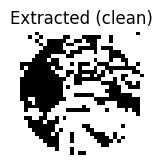

BER (jpeg q75): 0.0712890625


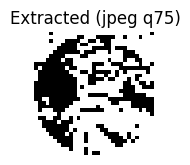

BER (small cutout): 0.095703125


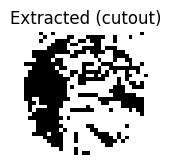

In [58]:
import math
import cv2
import numpy as np
from PIL import Image
import pywt
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

# =========================
# Adjustable hyperparameters
# =========================
DWT_LEVELS        = 2
DCT_BLOCK_SIZE    = 8
QIM_STEP          = 100.0
WAVELET_NAME      = 'haar'
WAVELET_MODE      = 'symmetric'
WATERMARK_SIZE    = 32

# =========================
# Small utilities
# =========================
def show_watermark(wm, title="Watermark", scale=4, threshold=None, save_path=None):
    """Display a single watermark (binarize if needed) with crisp pixels."""
    a = np.asarray(wm)
    thr = (0.5 if a.max() <= 1.0 else 127) if threshold is None else threshold
    a_bin = (a > thr).astype(np.uint8)
    a_disp = np.kron(a_bin, np.ones((max(1, int(scale)), max(1, int(scale))), dtype=np.uint8))
    plt.figure(figsize=(a_disp.shape[1]/80, a_disp.shape[0]/80))
    plt.imshow(a_disp, cmap="gray", vmin=0, vmax=1, interpolation="nearest")
    plt.title(title); plt.axis("off")
    if save_path: plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

def psnr(img_a_u8, img_b_u8):
    a = img_a_u8.astype(np.float64)
    b = img_b_u8.astype(np.float64)
    mse = np.mean((a - b) ** 2)
    return 100.0 if mse <= 1e-12 else 20.0 * math.log10(255.0 / math.sqrt(mse))

def bit_error_rate(true_bits_u8, pred_bits_u8):
    true_bits_u8 = np.asarray(true_bits_u8).astype(np.uint8).ravel()
    pred_bits_u8 = np.asarray(pred_bits_u8).astype(np.uint8).ravel()
    assert true_bits_u8.size == pred_bits_u8.size, "Mismatch in bit lengths."
    return np.count_nonzero(true_bits_u8 ^ pred_bits_u8) / true_bits_u8.size

def to_ycbcr_arrays(pil_rgb):
    """Return Y (float64), Cb (uint8), Cr (uint8)."""
    ycbcr = pil_rgb.convert("YCbCr")
    Y  = np.array(ycbcr.getchannel(0), dtype=np.float64)
    Cb = np.array(ycbcr.getchannel(1), dtype=np.uint8)
    Cr = np.array(ycbcr.getchannel(2), dtype=np.uint8)
    return Y, Cb, Cr

def from_ycbcr_arrays(Y_float, Cb_u8, Cr_u8):
    """Merge Y, Cb, Cr back to RGB (uint8)."""
    Y_u8 = np.rint(np.clip(Y_float, 0, 255)).astype(np.uint8)
    ycbcr = Image.merge("YCbCr", (Image.fromarray(Y_u8),
                                  Image.fromarray(Cb_u8),
                                  Image.fromarray(Cr_u8)))
    return ycbcr.convert("RGB")

def prepare_watermark_bits(path, size=WATERMARK_SIZE):
    """Load any image → grayscale → Otsu → resize to size×size, return 0/1 bits."""
    img = Image.open(path).convert("L")
    arr = np.array(img, dtype=np.uint8)
    _, thr = cv2.threshold(arr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thr = Image.fromarray(thr).resize((size, size), Image.NEAREST)
    bits = (np.array(thr, dtype=np.uint8) > 127).astype(np.uint8)
    return bits

# =========================
# DWT helpers (multi-level)
# =========================
def dwt2_levels(img_2d, levels=DWT_LEVELS):
    return pywt.wavedec2(img_2d, wavelet=WAVELET_NAME, level=levels, mode=WAVELET_MODE)

def idwt2_levels(coeffs):
    return pywt.waverec2(coeffs, wavelet=WAVELET_NAME, mode=WAVELET_MODE)

def get_detail_bands_all_levels(coeffs):
    """
    Return a list of (level_idx, band_tag, band_array_ref) for detail bands only.
    band_tag ∈ {'H','V'} (no diagonal band).
    """
    out = []
    levels = len(coeffs) - 1
    for l in range(levels, 0, -1):
        cH, cV, cD = coeffs[levels - l + 1]
        out.append((l, 'H', cH))
        out.append((l, 'V', cV))
    return out

def set_detail_band(coeffs, level_idx, band_tag, new_arr):
    """Write back a specific detail band at a given level."""
    levels = len(coeffs) - 1
    i = levels - level_idx + 1
    cH, cV, cD = coeffs[i]
    if band_tag == 'H':
        coeffs[i] = (new_arr, cV, cD)
    elif band_tag == 'V':
        coeffs[i] = (cH, new_arr, cD)

# =========================
# DCT (8×8 blockwise) helpers
# =========================
def dct_blocks_8x8(arr2d):
    """Blockwise 8×8 DCT with edge padding to multiples of 8."""
    H, W = arr2d.shape
    H8 = (H + 7) // 8 * 8
    W8 = (W + 7) // 8 * 8
    padded = np.pad(arr2d, ((0, H8 - H), (0, W8 - W)), mode='edge').astype(np.float64)
    D = np.empty((H8, W8), dtype=np.float64)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = padded[i:i+8, j:j+8]
            D[i:i+8, j:j+8] = dct(dct(blk.T, norm="ortho").T, norm="ortho")
    return D, H, W

def idct_blocks_8x8(D, H, W):
    """Inverse blockwise 8×8 DCT; crop back to original size."""
    H8, W8 = D.shape
    out = np.empty_like(D)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = D[i:i+8, j:j+8]
            out[i:i+8, j:j+8] = idct(idct(blk.T, norm="ortho").T, norm="ortho")
    return out[:H, :W]

# =========================
# QIM primitives (scalar) on a single value
# =========================
def qim_embed_scalar(x, bit, step):
    """Quantize x into the center of the bit-labeled interval with step Δ=step."""
    q = np.floor(x / step)
    return (q + (0.25 if bit == 0 else 0.75)) * step

def qim_llr_scalar(x, step):
    """Soft-decision score: >0 means closer to bit=1; <0 closer to bit=0."""
    x /= step
    frac = x - np.floor(x)
    return abs(frac - 0.25) - abs(frac - 0.75)

# =========================
# SVD-on-block helpers (inside an 8×8 DCT block)
# =========================
def svd_qim_embed_in_block(D8, bit, step, svd_idx=0):
    """Embed bit into the singular value of an 8x8 DCT block using QIM."""
    U, S, Vt = np.linalg.svd(D8, full_matrices=False)
    k = min(svd_idx, len(S) - 1)
    S[k] = qim_embed_scalar(S[k], int(bit), step)
    D8[:] = (U * S) @ Vt  # U @ diag(S) @ Vt

def svd_qim_llr_from_block(D8, step, svd_idx=0):
    """Extract the soft-decision score for a given bit."""
    _, S, _ = np.linalg.svd(D8, full_matrices=False)
    k = min(svd_idx, len(S) - 1)
    return qim_llr_scalar(S[k], step)

# =========================
# Embedding (Y channel only) — NO TILING, NO RANDOM
# =========================
def embed_watermark_y(y_luma, wm_bits_2d):
    """
    Embed size×size binary watermark into Y using deterministic round-robin mapping.
    - Never touches LL subbands.
    - No randomness: block k carries bit (k % n_bits).
    """
    H0, W0 = y_luma.shape
    if not (512 <= H0 <= 1080 and 512 <= W0 <= 1080):
        raise ValueError("Host image must be within 512–1080 px on BOTH height and width.")

    # Pad so DWT levels and 8×8 DCT align cleanly
    stride = 1 << DWT_LEVELS
    mult = stride if stride >= 8 else 8
    Hp = (H0 + mult - 1) // mult * mult
    Wp = (W0 + mult - 1) // mult * mult
    y_pad = np.pad(y_luma, ((0, Hp - H0), (0, Wp - W0)), mode='edge')

    # DWT
    coeffs = dwt2_levels(y_pad, DWT_LEVELS)
    detail_bands = get_detail_bands_all_levels(coeffs)

    wm_bits = wm_bits_2d.astype(np.uint8).ravel()
    n_bits  = wm_bits.size

    for lvl, tag, band in detail_bands:
        # DCT over the entire band (single region)
        D, Hb, Wb = dct_blocks_8x8(band)
        H8, W8 = D.shape
        n_rows, n_cols = H8 // 8, W8 // 8
        n_blocks = n_rows * n_cols

        # Deterministic round-robin mapping: block k → bit (k % n_bits)
        assign = np.arange(n_blocks, dtype=np.int32) % n_bits

        # Embed per-block
        for k in range(n_blocks):
            bit_index = int(assign[k])
            r = k // n_cols; c = k % n_cols
            i, j = r * 8, c * 8
            svd_qim_embed_in_block(
                D[i:i+8, j:j+8],
                int(wm_bits[bit_index]),
                QIM_STEP
            )

        # Write back the modified band
        band[:] = idct_blocks_8x8(D, Hb, Wb)
        set_detail_band(coeffs, lvl, tag, band)

    # Inverse DWT and crop back to original size
    y_wm_pad = idwt2_levels(coeffs)
    return y_wm_pad[:H0, :W0]

# =========================
# Extraction (blind) — NO TILING, NO RANDOM
# =========================
def extract_watermark_y(y_luma, wm_size=WATERMARK_SIZE):
    """
    Recreate the same deterministic round-robin mapping and do soft voting.
    """
    H0, W0 = y_luma.shape
    stride = 1 << DWT_LEVELS
    mult = stride if stride >= 8 else 8
    Hp = (H0 + mult - 1) // mult * mult
    Wp = (W0 + mult - 1) // mult * mult
    y_pad = np.pad(y_luma, ((0, Hp - H0), (0, Wp - W0)), mode='edge')

    coeffs = dwt2_levels(y_pad, DWT_LEVELS)
    detail_bands = get_detail_bands_all_levels(coeffs)

    n_bits = wm_size * wm_size
    soft_sum = np.zeros(n_bits, dtype=np.float64)

    for lvl, tag, band in detail_bands:
        D, Hb, Wb = dct_blocks_8x8(band)
        H8, W8 = D.shape
        n_rows, n_cols = H8 // 8, W8 // 8
        n_blocks = n_rows * n_cols

        # Same round-robin mapping
        assign = np.arange(n_blocks, dtype=np.int32) % n_bits

        for k in range(n_blocks):
            r = k // n_cols; c = k % n_cols
            i, j = r * 8, c * 8
            llr = svd_qim_llr_from_block(
                D[i:i+8, j:j+8],
                QIM_STEP
            )
            soft_sum[int(assign[k])] += llr

    bits = (soft_sum >= 0).astype(np.uint8)
    return bits.reshape(wm_size, wm_size)

# =========================
# High-level convenience I/O
# =========================
def embed_watermark(host_path, wm_path, out_path="watermarked.png"):
    """Embed watermark image into host image file and save the watermarked RGB."""
    rgb = Image.open(host_path).convert("RGB")
    Y, Cb, Cr = to_ycbcr_arrays(rgb)
    wm_bits = prepare_watermark_bits(wm_path, WATERMARK_SIZE)
    Y_wm = embed_watermark_y(Y, wm_bits)
    out_rgb = from_ycbcr_arrays(Y_wm, Cb, Cr)
    out_rgb.save(out_path)
    return np.array(rgb, dtype=np.uint8), np.array(out_rgb, dtype=np.uint8), wm_bits

def extract_watermark(image_path, wm_size=WATERMARK_SIZE):
    """Extract watermark bits (wm_size×wm_size) from a watermarked/attacked image file."""
    rgb = Image.open(image_path).convert("RGB")
    Y, _, _ = to_ycbcr_arrays(rgb)
    wm_bits = extract_watermark_y(Y, wm_size)
    return wm_bits

# =========================
# (Optional) simple attack helpers for testing
# =========================
def attack_jpeg(in_path, out_path, quality=80):
    Image.open(in_path).convert("RGB").save(out_path, quality=quality, subsampling=0, optimize=False)

def attack_small_resize(in_path, out_path, scale=0.9):
    img = Image.open(in_path).convert("RGB")
    w, h = img.size
    img2 = img.resize((max(1, int(w*scale)), max(1, int(h*scale))), Image.LANCZOS)
    img3 = img2.resize((w, h), Image.LANCZOS)
    img3.save(out_path)

def attack_blur(in_path, out_path, k=3):
    arr = np.array(Image.open(in_path).convert("RGB"), dtype=np.uint8)
    k = k if k % 2 == 1 else k+1
    arrb = cv2.GaussianBlur(arr, (k, k), 0)
    Image.fromarray(arrb).save(out_path)

def attack_small_cutout(in_path, out_path,
                        area_ratio=0.008,     # ≈0.8% of full image area per patch
                        num_patches=2,
                        shape="rect",         # "rect" | "circle"
                        fill="noise",         # "noise" | "black" | "avg" | "blur" | "inpaint"
                        blur_kernel=11,
                        seed=None):
    """Tiny cutouts while keeping size; seed only for reproducibility of the ATTACK (not watermark)."""
    img = Image.open(in_path).convert("RGB")
    arr = np.array(img, dtype=np.uint8)
    H, W, C = arr.shape
    rng = np.random.default_rng(seed)

    if fill == "blur":
        k = blur_kernel if blur_kernel % 2 == 1 else blur_kernel + 1
        blurred = cv2.GaussianBlur(arr, (k, k), 0)

    def rect_mask(x0, y0, w, h):
        m = np.zeros((H, W), dtype=np.uint8); m[y0:y0+h, x0:x0+w] = 255; return m

    def circle_mask(x0, y0, w, h):
        m = np.zeros((H, W), dtype=np.uint8)
        cy, cx = y0 + h // 2, x0 + w // 2; r = int(0.5 * max(w, h))
        yy, xx = np.ogrid[:H, :W]; m[(yy - cy)**2 + (xx - cx)**2 <= r*r] = 255; return m

    global_mean = arr.reshape(-1, C).mean(axis=0).astype(np.uint8)
    inpaint_accum_mask = np.zeros((H, W), dtype=np.uint8)

    for _ in range(max(1, int(num_patches))):
        w = max(1, int(round(np.sqrt(area_ratio) * W)))
        h = max(1, int(round(np.sqrt(area_ratio) * H)))
        x0 = int(rng.integers(0, max(1, W - w))); y0 = int(rng.integers(0, max(1, H - h)))
        mask = rect_mask(x0, y0, w, h) if shape == "rect" else circle_mask(x0, y0, w, h)

        if fill == "black":
            arr[mask == 255] = 0
        elif fill == "avg":
            arr[mask == 255] = global_mean
        elif fill == "noise":
            noise = rng.integers(0, 256, size=(H, W, C), dtype=np.uint8)
            arr[mask == 255] = noise[mask == 255]
        elif fill == "blur":
            arr[mask == 255] = blurred[mask == 255]
        elif fill == "inpaint":
            inpaint_accum_mask = np.maximum(inpaint_accum_mask, mask)
        else:
            raise ValueError("fill must be one of: 'noise','black','avg','blur','inpaint'")

    if fill == "inpaint" and np.any(inpaint_accum_mask):
        bgr = cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
        bgr = cv2.inpaint(bgr, inpaint_accum_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
        arr = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    Image.fromarray(arr).save(out_path)

# =========================
# Example usage (uncomment to run locally)
# =========================
if __name__ == "__main__":
    host_path = "./images/i512.png"
    wm_path   = "./images/image512.jpg"
    out_path  = "./images/watermarked.jpg"

    # Embed
    host_u8, watermarked_u8, wm_bits_true = embed_watermark(host_path, wm_path, out_path)
    print("PSNR host vs watermarked:", psnr(host_u8, watermarked_u8), "dB")

    # Extract from clean
    bits_clean = extract_watermark(out_path, WATERMARK_SIZE)
    print("BER (clean):", bit_error_rate(wm_bits_true, bits_clean))
    show_watermark(bits_clean, title="Extracted (clean)")

    # JPEG attack
    attack_jpeg(out_path, "./images/wm_jpeg75.jpg", quality=75)
    bits_jpeg = extract_watermark("./images/wm_jpeg75.jpg", WATERMARK_SIZE)
    print("BER (jpeg q75):", bit_error_rate(wm_bits_true, bits_jpeg))
    show_watermark(bits_jpeg, title="Extracted (jpeg q75)")

    # Small cutout attack
    attack_small_cutout(out_path, "./images/wm_cutout_black.jpg",
                        area_ratio=0.05, num_patches=1, shape="rect", fill="black", seed=42)
    bits_cut = extract_watermark("./images/wm_cutout_black.jpg", WATERMARK_SIZE)
    print("BER (small cutout):", bit_error_rate(wm_bits_true, bits_cut))
    show_watermark(bits_cut, title="Extracted (cutout)")

# with rotation

PSNR host vs watermarked: 36.38812128729276 dB
BER (clean): 0.125


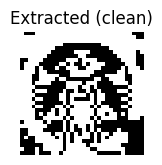

BER (jpeg q75): 0.201171875


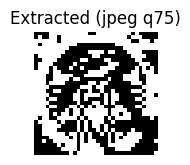

BER (small cutout): 0.1591796875


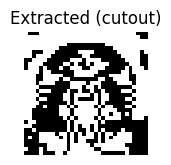

BER (rotation): 0.5966796875


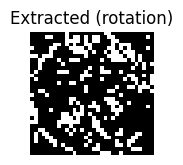

In [66]:
"""
Simple DWT+DCT+SVD+QIM Watermarking (NO TILING, NO RANDOM SEED, Blind, LL untouched)
------------------------------------------------------------------------------------

Design
- Work in Y (luma) channel only; keep original Cb/Cr untouched.
- 2-level DWT; embed ONLY in detail bands (H/V and optionally D). Never touch LL.
- For each (level, band):
    * 8×8 block DCT over the whole band (one big region; no tiling)
    * Use a 4×4 mid/low-mid patch inside each 8×8 block (rows/cols [1:5])
    * SVD that 4×4 patch; QIM-quantize ONE singular value (σ_k) to encode bits
- Deterministic, seedless mapping: round-robin across blocks (block k → bit k % n_bits)
- Repetition comes automatically when #blocks > #bits. Soft voting at extraction.

Notes
- Large QIM_STEP (e.g., 80–120) increases JPEG robustness but reduces image quality (PSNR).
- Keep host image size within 512–1080 px on BOTH height and width.
"""

import math
import cv2
import numpy as np
from PIL import Image
import pywt
from scipy.fftpack import dct, idct
import matplotlib.pyplot as plt

# =========================
# Adjustable hyperparameters
# =========================
DWT_LEVELS        = 2              # 2-level DWT
DCT_BLOCK_SIZE    = 8
QIM_STEP          = 80.0
WAVELET_NAME      = 'haar'
WAVELET_MODE      = 'symmetric'
WATERMARK_SIZE    = 32             # watermark is 32×32 binary

# =========================
# Small utilities
# =========================
def show_watermark(wm, title="Watermark", scale=4, threshold=None, save_path=None):
    """Display a single watermark (binarize if needed) with crisp pixels."""
    a = np.asarray(wm)
    thr = (0.5 if a.max() <= 1.0 else 127) if threshold is None else threshold
    a_bin = (a > thr).astype(np.uint8)
    a_disp = np.kron(a_bin, np.ones((max(1, int(scale)), max(1, int(scale))), dtype=np.uint8))
    plt.figure(figsize=(a_disp.shape[1]/80, a_disp.shape[0]/80))
    plt.imshow(a_disp, cmap="gray", vmin=0, vmax=1, interpolation="nearest")
    plt.title(title); plt.axis("off")
    if save_path: plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()

def psnr(img_a_u8, img_b_u8):
    a = img_a_u8.astype(np.float64)
    b = img_b_u8.astype(np.float64)
    mse = np.mean((a - b) ** 2)
    return 100.0 if mse <= 1e-12 else 20.0 * math.log10(255.0 / math.sqrt(mse))

def bit_error_rate(true_bits_u8, pred_bits_u8):
    true_bits_u8 = np.asarray(true_bits_u8).astype(np.uint8).ravel()
    pred_bits_u8 = np.asarray(pred_bits_u8).astype(np.uint8).ravel()
    assert true_bits_u8.size == pred_bits_u8.size, "Mismatch in bit lengths."
    return np.count_nonzero(true_bits_u8 ^ pred_bits_u8) / true_bits_u8.size

def to_ycbcr_arrays(pil_rgb):
    """Return Y (float64), Cb (uint8), Cr (uint8)."""
    ycbcr = pil_rgb.convert("YCbCr")
    Y  = np.array(ycbcr.getchannel(0), dtype=np.float64)
    Cb = np.array(ycbcr.getchannel(1), dtype=np.uint8)
    Cr = np.array(ycbcr.getchannel(2), dtype=np.uint8)
    return Y, Cb, Cr

def from_ycbcr_arrays(Y_float, Cb_u8, Cr_u8):
    """Merge Y, Cb, Cr back to RGB (uint8)."""
    Y_u8 = np.rint(np.clip(Y_float, 0, 255)).astype(np.uint8)
    ycbcr = Image.merge("YCbCr", (Image.fromarray(Y_u8),
                                  Image.fromarray(Cb_u8),
                                  Image.fromarray(Cr_u8)))
    return ycbcr.convert("RGB")

def prepare_watermark_bits(path, size=WATERMARK_SIZE):
    """Load any image → grayscale → Otsu → resize to size×size, return 0/1 bits."""
    img = Image.open(path).convert("L")
    arr = np.array(img, dtype=np.uint8)
    _, thr = cv2.threshold(arr, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thr = Image.fromarray(thr).resize((size, size), Image.NEAREST)
    bits = (np.array(thr, dtype=np.uint8) > 127).astype(np.uint8)
    return bits

# =========================
# DWT helpers (multi-level)
# =========================
def dwt2_levels(img_2d, levels=DWT_LEVELS):
    return pywt.wavedec2(img_2d, wavelet=WAVELET_NAME, level=levels, mode=WAVELET_MODE)

def idwt2_levels(coeffs):
    return pywt.waverec2(coeffs, wavelet=WAVELET_NAME, mode=WAVELET_MODE)

def get_detail_bands_all_levels(coeffs):
    """
    Return a list of (level_idx, band_tag, band_array_ref) for detail bands only.
    band_tag ∈ {'H','V'} (no diagonal band).
    """
    out = []
    levels = len(coeffs) - 1
    for l in range(levels, 0, -1):
        cH, cV, cD = coeffs[levels - l + 1]
        out.append((l, 'H', cH))
        out.append((l, 'V', cV))
    return out

def set_detail_band(coeffs, level_idx, band_tag, new_arr):
    """Write back a specific detail band at a given level."""
    levels = len(coeffs) - 1
    i = levels - level_idx + 1
    cH, cV, cD = coeffs[i]
    if band_tag == 'H':
        coeffs[i] = (new_arr, cV, cD)
    elif band_tag == 'V':
        coeffs[i] = (cH, new_arr, cD)

# =========================
# DCT (8×8 blockwise) helpers
# =========================
def dct_blocks_8x8(arr2d):
    """Blockwise 8×8 DCT with edge padding to multiples of 8."""
    H, W = arr2d.shape
    H8 = (H + 7) // 8 * 8
    W8 = (W + 7) // 8 * 8
    padded = np.pad(arr2d, ((0, H8 - H), (0, W8 - W)), mode='edge').astype(np.float64)
    D = np.empty((H8, W8), dtype=np.float64)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = padded[i:i+8, j:j+8]
            D[i:i+8, j:j+8] = dct(dct(blk.T, norm="ortho").T, norm="ortho")
    return D, H, W

def idct_blocks_8x8(D, H, W):
    """Inverse blockwise 8×8 DCT; crop back to original size."""
    H8, W8 = D.shape
    out = np.empty_like(D)
    for i in range(0, H8, 8):
        for j in range(0, W8, 8):
            blk = D[i:i+8, j:j+8]
            out[i:i+8, j:j+8] = idct(idct(blk.T, norm="ortho").T, norm="ortho")
    return out[:H, :W]

# =========================
# QIM primitives (scalar) on a single value
# =========================
def qim_embed_scalar(x, bit, step):
    """Quantize x into the center of the bit-labeled interval with step Δ=step."""
    q = np.floor(x / step)
    return (q + (0.25 if bit == 0 else 0.75)) * step

def qim_llr_scalar(x, step):
    """Soft-decision score: >0 means closer to bit=1; <0 closer to bit=0."""
    x /= step
    frac = x - np.floor(x)
    return abs(frac - 0.25) - abs(frac - 0.75)

# =========================
# SVD-on-block helpers (inside an 8×8 DCT block)
# =========================
def svd_qim_embed_in_block(D8, bit, step, svd_idx=0):
    """Embed bit into the singular value of an 8x8 DCT block using QIM."""
    U, S, Vt = np.linalg.svd(D8, full_matrices=False)
    k = min(svd_idx, len(S) - 1)
    S[k] = qim_embed_scalar(S[k], int(bit), step)
    D8[:] = (U * S) @ Vt  # U @ diag(S) @ Vt

def svd_qim_llr_from_block(D8, step, svd_idx=0):
    """Extract the soft-decision score for a given bit."""
    _, S, _ = np.linalg.svd(D8, full_matrices=False)
    k = min(svd_idx, len(S) - 1)
    return qim_llr_scalar(S[k], step)

# =========================
# Embedding (Y channel only) — NO TILING, NO RANDOM
# =========================
def embed_watermark_y(y_luma, wm_bits_2d):
    """
    Embed size×size binary watermark into Y using deterministic round-robin mapping.
    - Never touches LL subbands.
    - No randomness: block k carries bit (k % n_bits).
    """
    H0, W0 = y_luma.shape
    if not (512 <= H0 <= 1080 and 512 <= W0 <= 1080):
        raise ValueError("Host image must be within 512–1080 px on BOTH height and width.")

    # Pad so DWT levels and 8×8 DCT align cleanly
    stride = 1 << DWT_LEVELS
    mult = stride if stride >= 8 else 8
    Hp = (H0 + mult - 1) // mult * mult
    Wp = (W0 + mult - 1) // mult * mult
    y_pad = np.pad(y_luma, ((0, Hp - H0), (0, Wp - W0)), mode='edge')

    # DWT
    coeffs = dwt2_levels(y_pad, DWT_LEVELS)
    detail_bands = get_detail_bands_all_levels(coeffs)

    wm_bits = wm_bits_2d.astype(np.uint8).ravel()
    n_bits  = wm_bits.size

    for lvl, tag, band in detail_bands:
        # DCT over the entire band (single region)
        D, Hb, Wb = dct_blocks_8x8(band)
        H8, W8 = D.shape
        n_rows, n_cols = H8 // 8, W8 // 8
        n_blocks = n_rows * n_cols

        # Deterministic round-robin mapping: block k → bit (k % n_bits)
        assign = np.arange(n_blocks, dtype=np.int32) % n_bits

        # Embed per-block
        for k in range(n_blocks):
            bit_index = int(assign[k])
            r = k // n_cols; c = k % n_cols
            i, j = r * 8, c * 8
            svd_qim_embed_in_block(
                D[i:i+8, j:j+8],
                int(wm_bits[bit_index]),
                QIM_STEP
            )

        # Write back the modified band
        band[:] = idct_blocks_8x8(D, Hb, Wb)
        set_detail_band(coeffs, lvl, tag, band)

    # Inverse DWT and crop back to original size
    y_wm_pad = idwt2_levels(coeffs)
    return y_wm_pad[:H0, :W0]

# =========================
# Extraction (blind) — NO TILING, NO RANDOM
# =========================
def extract_watermark_y(y_luma, wm_size=WATERMARK_SIZE, return_score=False):
    """
    Recreate the same deterministic round-robin mapping and do soft voting.
    """
    H0, W0 = y_luma.shape
    stride = 1 << DWT_LEVELS
    mult = stride if stride >= 8 else 8
    Hp = (H0 + mult - 1) // mult * mult
    Wp = (W0 + mult - 1) // mult * mult
    y_pad = np.pad(y_luma, ((0, Hp - H0), (0, Wp - W0)), mode='edge')

    coeffs = dwt2_levels(y_pad, DWT_LEVELS)
    detail_bands = get_detail_bands_all_levels(coeffs)

    n_bits = wm_size * wm_size
    soft_sum = np.zeros(n_bits, dtype=np.float64)

    for lvl, tag, band in detail_bands:
        D, Hb, Wb = dct_blocks_8x8(band)
        H8, W8 = D.shape
        n_rows, n_cols = H8 // 8, W8 // 8
        n_blocks = n_rows * n_cols

        # Same round-robin mapping
        assign = np.arange(n_blocks, dtype=np.int32) % n_bits

        for k in range(n_blocks):
            r = k // n_cols; c = k % n_cols
            i, j = r * 8, c * 8
            llr = svd_qim_llr_from_block(
                D[i:i+8, j:j+8],
                QIM_STEP
            )
            soft_sum[int(assign[k])] += llr

    bits = (soft_sum >= 0).astype(np.uint8)

    # Reshape to 2D form for convenience in display (for rotation)
    if return_score:
        return bits.reshape(wm_size, wm_size), float(np.sum(np.abs(soft_sum)))
    
    return bits.reshape(wm_size, wm_size)

# =========================
# High-level convenience I/O
# =========================
def embed_watermark(host_path, wm_path, out_path="watermarked.png"):
    """Embed watermark image into host image file and save the watermarked RGB."""
    rgb = Image.open(host_path).convert("RGB")
    Y, Cb, Cr = to_ycbcr_arrays(rgb)
    wm_bits = prepare_watermark_bits(wm_path, WATERMARK_SIZE)
    Y_wm = embed_watermark_y(Y, wm_bits)
    out_rgb = from_ycbcr_arrays(Y_wm, Cb, Cr)
    out_rgb.save(out_path)
    return np.array(rgb, dtype=np.uint8), np.array(out_rgb, dtype=np.uint8), wm_bits

def extract_watermark(image_path, wm_size=WATERMARK_SIZE):
    """Extract watermark bits (wm_size×wm_size) from a watermarked/attacked image file."""
    rgb = Image.open(image_path).convert("RGB")
    Y, _, _ = to_ycbcr_arrays(rgb)
    wm_bits = extract_watermark_y(Y, wm_size)
    return wm_bits

def extract_watermark_with_rotation(img_path, wm_size=WATERMARK_SIZE,
                                    angle_range=(-5, 5), step=0.5):
    rgb = Image.open(img_path).convert("RGB")
    best_bits, best_score = None, -1.0
    for ang in np.arange(angle_range[0], angle_range[1]+1e-3, step):
        rot = rgb.rotate(ang, resample=Image.BICUBIC, expand=False)
        Y, _, _ = to_ycbcr_arrays(rot)
        bits, score = extract_watermark_y(Y, wm_size, return_score=True)
        if score > best_score:
            best_score, best_bits = score, bits
    return best_bits

# =========================
# (Optional) simple attack helpers for testing
# =========================
def attack_jpeg(in_path, out_path, quality=80):
    Image.open(in_path).convert("RGB").save(out_path, quality=quality, subsampling=0, optimize=False)

def attack_small_resize(in_path, out_path, scale=0.9):
    img = Image.open(in_path).convert("RGB")
    w, h = img.size
    img2 = img.resize((max(1, int(w*scale)), max(1, int(h*scale))), Image.LANCZOS)
    img3 = img2.resize((w, h), Image.LANCZOS)
    img3.save(out_path)

def attack_blur(in_path, out_path, k=3):
    arr = np.array(Image.open(in_path).convert("RGB"), dtype=np.uint8)
    k = k if k % 2 == 1 else k+1
    arrb = cv2.GaussianBlur(arr, (k, k), 0)
    Image.fromarray(arrb).save(out_path)

def attack_small_cutout(in_path, out_path,
                        area_ratio=0.008,     # ≈0.8% of full image area per patch
                        num_patches=2,
                        shape="rect",         # "rect" | "circle"
                        fill="noise",         # "noise" | "black" | "avg" | "blur" | "inpaint"
                        blur_kernel=11,
                        seed=None):
    """Tiny cutouts while keeping size; seed only for reproducibility of the ATTACK (not watermark)."""
    img = Image.open(in_path).convert("RGB")
    arr = np.array(img, dtype=np.uint8)
    H, W, C = arr.shape
    rng = np.random.default_rng(seed)

    if fill == "blur":
        k = blur_kernel if blur_kernel % 2 == 1 else blur_kernel + 1
        blurred = cv2.GaussianBlur(arr, (k, k), 0)

    def rect_mask(x0, y0, w, h):
        m = np.zeros((H, W), dtype=np.uint8); m[y0:y0+h, x0:x0+w] = 255; return m

    def circle_mask(x0, y0, w, h):
        m = np.zeros((H, W), dtype=np.uint8)
        cy, cx = y0 + h // 2, x0 + w // 2; r = int(0.5 * max(w, h))
        yy, xx = np.ogrid[:H, :W]; m[(yy - cy)*2 + (xx - cx)*2 <= r*r] = 255; return m

    global_mean = arr.reshape(-1, C).mean(axis=0).astype(np.uint8)
    inpaint_accum_mask = np.zeros((H, W), dtype=np.uint8)

    for _ in range(max(1, int(num_patches))):
        w = max(1, int(round(np.sqrt(area_ratio) * W)))
        h = max(1, int(round(np.sqrt(area_ratio) * H)))
        x0 = int(rng.integers(0, max(1, W - w))); y0 = int(rng.integers(0, max(1, H - h)))
        mask = rect_mask(x0, y0, w, h) if shape == "rect" else circle_mask(x0, y0, w, h)

        if fill == "black":
            arr[mask == 255] = 0
        elif fill == "avg":
            arr[mask == 255] = global_mean
        elif fill == "noise":
            noise = rng.integers(0, 256, size=(H, W, C), dtype=np.uint8)
            arr[mask == 255] = noise[mask == 255]
        elif fill == "blur":
            arr[mask == 255] = blurred[mask == 255]
        elif fill == "inpaint":
            inpaint_accum_mask = np.maximum(inpaint_accum_mask, mask)
        else:
            raise ValueError("fill must be one of: 'noise','black','avg','blur','inpaint'")

    if fill == "inpaint" and np.any(inpaint_accum_mask):
        bgr = cv2.cvtColor(arr, cv2.COLOR_RGB2BGR)
        bgr = cv2.inpaint(bgr, inpaint_accum_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
        arr = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

    Image.fromarray(arr).save(out_path)

# =========================
# Example usage (uncomment to run locally)
# =========================
if __name__ == "__main__":
    host_path = "./images/image512.jpg"
    wm_path   = "./images/s.jpg"
    out_path  = "./images/watermarked.png"

    # Embed
    host_u8, watermarked_u8, wm_bits_true = embed_watermark(host_path, wm_path, out_path)
    print("PSNR host vs watermarked:", psnr(host_u8, watermarked_u8), "dB")

    # Extract from clean
    bits_clean = extract_watermark(out_path, WATERMARK_SIZE)
    print("BER (clean):", bit_error_rate(wm_bits_true, bits_clean))
    show_watermark(bits_clean, title="Extracted (clean)")

    # JPEG attack
    attack_jpeg(out_path, "./images/wm_jpeg75.jpg", quality=75)
    bits_jpeg = extract_watermark("./images/wm_jpeg75.jpg", WATERMARK_SIZE)
    print("BER (jpeg q75):", bit_error_rate(wm_bits_true, bits_jpeg))
    show_watermark(bits_jpeg, title="Extracted (jpeg q75)")

    # Small cutout attack
    attack_small_cutout(out_path, "./images/wm_cutout_black.png",
                        area_ratio=0.05, num_patches=1, shape="rect", fill="black", seed=42)
    bits_cut = extract_watermark("./images/wm_cutout_black.png", WATERMARK_SIZE)
    print("BER (small cutout):", bit_error_rate(wm_bits_true, bits_cut))
    show_watermark(bits_cut, title="Extracted (cutout)")

    # Small rotation attack
    # Create a rotated version of the watermarked image and save it
    rot_img = Image.open(out_path).convert("RGB").rotate(2, resample=Image.BICUBIC, expand=False)
    rot_img.save("./images/wm_rot.png")

    bits_rot = extract_watermark_with_rotation("./images/wm_rot.png", WATERMARK_SIZE)
    print("BER (rotation):", bit_error_rate(wm_bits_true, bits_rot))
    show_watermark(bits_rot, title="Extracted (rotation)")